Based on the great [work](https://www.kaggle.com/stefanbuenten/mnist-test-with-fastai) of Stefan Langenbach

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


## Inspect data

In [5]:
!ls ../data

dogscats  mnist


In [6]:
PATH = "../data/mnist"
test_df = pd.read_csv(f"{PATH}/test.csv")
train_df = pd.read_csv(f"{PATH}/train.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(train_df.shape, test_df.shape)

(42000, 785) (28000, 784)


## Prepare data

In [10]:
# create validation dataset
valid_df = train_df.sample(frac=0.2, random_state=42)
valid_df.shape

(8400, 785)

In [11]:
# drop validation data from train dataset
train_df = train_df.drop(valid_df.index)
train_df.shape

(33600, 785)

In [12]:
# separate labels from data
Y_train = train_df['label']
Y_valid = valid_df['label']
X_train = train_df.drop('label', axis=1)
X_valid = valid_df.drop('label', axis=1)

In [13]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


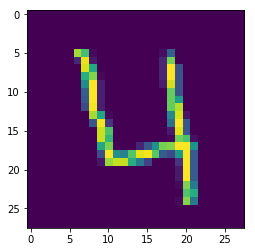

In [14]:
# visualize a digit
img = X_train.iloc[2, :].values.reshape(28,28)
plt.imshow(img)

## Preprocessing

In [15]:
def reshape_img(matrix):
    """
    Reshape an existing 2D pandas.dataframe into 3D-numpy.ndarray
    """
    try:
        return matrix.values.reshape(-1, 28, 28)
    except AttributeError as e:
        print(e)

In [16]:
def add_color_channel(matrix):
    """
    Add missing color channels to previously reshaped image
    """
    matrix = np.stack((matrix, ) *3, axis = -1)
    return matrix

In [17]:
def convert_ndarray(matrix):
    """
    Convert pandas.series into numpy.ndarray
    """
    try:
        return matrix.values.flatten()
    except AttributeError as e:
        print(e)

In [18]:
# reshape data and add color channels
X_train = reshape_img(X_train)
X_train = add_color_channel(X_train)
X_valid = reshape_img(X_valid)
X_valid = add_color_channel(X_valid)
test_df = reshape_img(test_df)
test_df = add_color_channel(test_df)

In [19]:
# convert y_train and y_valid into proper numpy.ndarray
Y_train = convert_ndarray(Y_train)
Y_valid = convert_ndarray(Y_valid)

In [20]:
# run sanity checks
preprocessed_data = [X_train, Y_train, X_valid, Y_valid, test_df]
print([e.shape for e in preprocessed_data])
print([type(e) for e in preprocessed_data])

[(33600, 28, 28, 3), (33600,), (8400, 28, 28, 3), (8400,), (28000, 28, 28, 3)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


## Model

In [21]:
# define architecture
arch = resnext50
sz = 28
bs = 64
classes = np.unique(Y_train)

In [22]:
data = ImageClassifierData.from_arrays(path='tmp', 
                                       trn=(X_train, Y_train),
                                       val=(X_valid, Y_valid),
                                       classes=Y_train,
                                       test=test_df,
                                       tfms=tfms_from_model(arch, sz))

In [23]:
# run learner with precompute enabled
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 438/438 [00:25<00:00, 17.25it/s]


In [24]:
# find optimal learning rate
lrf = learn.lr_find()

 83%|████████▎ | 437/525 [00:08<00:02, 34.51it/s, loss=2.44] 


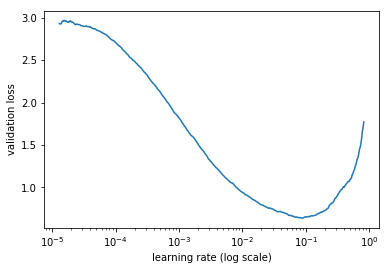

In [25]:
# plot loss vs. learning rate
learn.sched.plot()

In [26]:
lr = 1e-2

#### 3) Train last layer from precomputed activations for 1-2 epochs

In [27]:
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.344707   0.228265   0.926071  
    1      0.267906   0.19348    0.936667                    
    2      0.237812   0.175359   0.943571                    
    3      0.209713   0.161392   0.94869                     
    4      0.211681   0.159474   0.948571                    



[array([0.15947]), 0.9485714285714286]

Add dropout

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.400144   0.243007   0.923214  
    1      0.326341   0.207875   0.934167                    
    2      0.285312   0.184702   0.940833                    
    3      0.262124   0.173955   0.947262                    
    4      0.261487   0.170556   0.944643                    



[array([0.17056]), 0.9446428571428571]

#### 4) Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [29]:
learn.precompute=False
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.235854   0.159884   0.95      
    1      0.256763   0.157216   0.949524                    
    2      0.233995   0.150821   0.953452                    
    3      0.212384   0.152396   0.951905                    
    4      0.216672   0.149599   0.953452                    



[array([0.1496]), 0.9534523809523809]

#### 5) Unfreeze all layers

In [30]:
learn.unfreeze()

#### 6) Set earlier layers to 3x-10x lower learning rate than next higher layer

In [34]:
lr=np.array([1e-5,1e-4,1e-3])

#### 7) Use lr_find() again

In [32]:
lrf=learn.lr_find()

 83%|████████▎ | 438/525 [00:58<00:10,  7.99it/s, loss=1.49] 

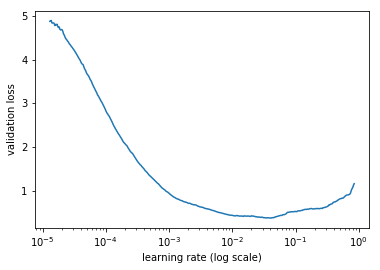

In [33]:
learn.sched.plot()

#### 8) Train full network with cycle_mult=2 until over-fitting

In [35]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.437275   0.274686   0.917857  
    1      0.228113   0.143799   0.957976                    
    2      0.185304   0.136368   0.95881                     
    3      0.128891   0.101248   0.969405                    
    4      0.10972    0.09148    0.973452                     
    5      0.085191   0.08745    0.973571                     
    6      0.087694   0.084293   0.975357                     


[array([0.08429]), 0.9753571428571428]

#### Add test time augmentation

In [36]:
# get accuracy for validation set
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9753571428571428

In [37]:
# predict on test set
%time log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
probs_test.shape

CPU times: user 1min 52s, sys: 15.7 s, total: 2min 8s
Wall time: 1min 37s


(28000, 10)

## Submission

In [38]:
# create dataframe from probabilities
df = pd.DataFrame(probs_test)

In [39]:
# increase index by 1 to obtain proper ImageIDs
df.index += 1

In [40]:
# create new colum containing label with highest probability for each digit
df = df.assign(Label = df.values.argmax(axis=1))

In [41]:
# replicate index as dedicated ImageID column necessary for submission
df = df.assign(ImageId = df.index.values)

In [42]:
# drop individual probabilites
df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)

In [43]:
# reorder columns for submission
df = df[["ImageId", "Label"]]

In [44]:
# run sanity checks
df.head()


,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3


In [45]:
# ...
df.tail()

,ImageId,Label
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9
28000,28000,2


In [46]:
# ...
df.shape

(28000, 2)

In [48]:
# write dataframe to CSV
comp_name = "digit_recognizer"
version = 'v1'
df.to_csv(f"sub_{comp_name}_{arch.__name__}_{version}.csv", index=False)